### Importing Libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

### Loading the dataset

In [17]:
df = pd.read_csv('../SavedData/dataset2_cleaned.csv')
df_copy= df.copy()
df['Datetime'] = pd.to_datetime(df['Datetime'])
df_copy['Datetime'] = pd.to_datetime(df_copy['Datetime'])
#df.set_index('Datetime', inplace=True)

df

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime
0,01/01/2023,00:00:00,678330503.0,2971.000000,1584.00,NaN,Westport Care Home,2023-01-01 00:00:00
1,01/01/2023,00:00:00,472213568.0,3792.000000,1950.00,NaN,Barbiee Boutique,2023-01-01 00:00:00
2,01/01/2023,00:00:00,472213568.0,3012.000000,-780.00,283027736.0,NaN,2023-01-01 00:00:00
3,01/01/2023,00:00:00,283027736.0,1787.000000,780.00,472213568.0,NaN,2023-01-01 00:00:00
4,01/01/2023,00:00:00,624500124.0,3226.000000,1825.00,NaN,Fat Face,2023-01-01 00:00:00
...,...,...,...,...,...,...,...,...
229189,06/12/2023,20:54:00,581655972.0,45935.206861,-41.06,NaN,Tesco,2023-12-06 20:54:00
229190,06/12/2023,20:55:00,786141370.0,-244.837500,-62.35,NaN,Sainsbury Local,2023-12-06 20:55:00
229191,06/12/2023,21:05:00,824916823.0,9709.172159,-32.94,NaN,Deliveroo,2023-12-06 21:05:00
229192,06/12/2023,21:13:00,366550080.0,26834.165794,-19.25,NaN,Amazon,2023-12-06 21:13:00


### Splitting the dataset into training and testing

In [18]:
training_transactions, testing_transactions = train_test_split(df, test_size=0.2, random_state=2)

training_payments_df = training_transactions[training_transactions['Amount'] > 0]
training_expenditures_df = training_transactions[training_transactions['Amount'] < 0]
training_expenditures_df["Amount"] = training_expenditures_df["Amount"].abs()

testing_payments_df = testing_transactions[testing_transactions['Amount'] > 0]
testing_expenditures_df = testing_transactions[testing_transactions['Amount'] < 0]
testing_expenditures_df["Amount"] = testing_expenditures_df["Amount"].abs()


/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/610568987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_expenditures_df["Amount"] = training_expenditures_df["Amount"].abs()
/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/610568987.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_expenditures_df["Amount"] = testing_expenditures_df["Amount"].abs()


## Creating an anomaly detection model based on TimeStamps 

### Expenditures df

In [19]:
training_expenditures_df

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime
98763,01/06/2023,11:43:00,660561861.0,1069.557925,12.99,NaN,Sports Direct,2023-06-01 11:43:00
202021,31/10/2023,23:59:00,229205098.0,8430.205394,7.00,NaN,Xbox,2023-10-31 23:59:00
9195,08/01/2023,10:59:00,191161970.0,1174.555000,52.39,NaN,Tesco,2023-01-08 10:59:00
187042,11/10/2023,08:32:00,519933553.0,-354.791496,18.22,NaN,Tesco,2023-10-11 08:32:00
138671,01/08/2023,09:57:00,762700245.0,1756.224700,38.97,NaN,Sports Direct,2023-08-01 09:57:00
...,...,...,...,...,...,...,...,...
175638,30/09/2023,08:26:00,973086490.0,8501.682677,39.28,NaN,Coop Local,2023-09-30 08:26:00
95816,31/05/2023,23:59:00,737645298.0,-1415.637550,18.99,NaN,PureGym,2023-05-31 23:59:00
203245,01/11/2023,03:41:00,304455868.0,3349.715880,14.48,NaN,Topshop,2023-11-01 03:41:00
100879,05/06/2023,08:23:00,198630866.0,-222.556324,61.23,NaN,Tesco,2023-06-05 08:23:00


In [40]:
training_expenditures_df['Hour'] = training_expenditures_df['Datetime'].dt.hour

# Group by 'Account No' and 'Hour', then count the frequency of each 'Hour' for an account
hourly_interactions = training_expenditures_df.groupby(['Account No', 'Hour']).size().reset_index(name='Frequency')

# Find the hours with the least frequency for each account
least_frequent_hours = hourly_interactions.sort_values(['Account No', 'Frequency', 'Hour']).drop_duplicates('Account No', keep='first')

def find_hours_in_lowest_quintile(group):
    # Determine the 10th percentile (lowest quintile) of frequency for the group
    threshold = group['Frequency'].quantile(0.1)
    # Return all hours where the frequency is less than or equal to this threshold
    return group[group['Frequency'] <= threshold]['Hour'].tolist()

# Group by 'Account No' to calculate and gather hours in the lowest quintile for each account
accounts_least_frqt_hour = hourly_interactions.groupby('Account No').apply(find_hours_in_lowest_quintile).reset_index(name='Hours in Lowest 20% Quintile')
accounts_least_frqt_hour.set_index('Account No', inplace=True)
accounts_hours_dict = accounts_least_frqt_hour['Hours in Lowest 20% Quintile'].to_dict()

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/2697128796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_expenditures_df['Hour'] = training_expenditures_df['Datetime'].dt.hour


In [38]:
testing_expenditures_df['Hour'] = testing_expenditures_df['Datetime'].dt.hour

def check_anomaly(row):
    account_no = row['Account No']
    hour = row['Hour']
    least_frqt_hours = accounts_hours_dict.get(account_no, [])
    return hour in least_frqt_hours

# Apply the function to each row in the testing dataframe
testing_expenditures_df['Anomaly'] = testing_expenditures_df.apply(check_anomaly, axis=1)

# Filter the testing_expenditures_df to only include rows where 'Anomaly' is True
anomalies_df = testing_expenditures_df[testing_expenditures_df['Anomaly'] == True]

anomalies_df



/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/4139403026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_expenditures_df['Hour'] = testing_expenditures_df['Datetime'].dt.hour
/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/4139403026.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_expenditures_df['Anomaly'] = testing_expenditures_df.apply(check_anomaly, axis=1)


,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,Hour,Anomaly,DayOfWeek,DayOfMonth,MonthOfYear
3133,01/01/2023,00:00:00,279149837.0,1532.010000,100.00,NaN,Grand Union BJJ,2023-01-01 00:00:00,0,True,6,1,1
103368,10/06/2023,12:10:00,833499132.0,823.030350,102.75,NaN,Topshop,2023-06-10 12:10:00,12,True,5,10,6
91479,27/05/2023,21:17:00,766941757.0,5722.075357,26.28,NaN,JustEat,2023-05-27 21:17:00,21,True,5,27,5
160039,01/09/2023,15:31:00,871866387.0,-347.918500,113.62,NaN,Selfridges,2023-09-01 15:31:00,15,True,4,1,9
2841,01/01/2023,00:00:00,782013626.0,3405.010000,15.99,NaN,Netflix,2023-01-01 00:00:00,0,True,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142051,07/08/2023,02:07:00,815385232.0,8250.566744,42.17,NaN,Amazon,2023-08-07 02:07:00,2,True,0,7,8
52255,19/03/2023,18:24:00,965038148.0,94.900066,40.43,NaN,Deliveroo,2023-03-19 18:24:00,18,True,6,19,3
225345,01/12/2023,02:41:00,108931112.0,16892.263207,34.63,NaN,Deliveroo,2023-12-01 02:41:00,2,True,4,1,12
125668,16/07/2023,00:50:00,987656636.0,6306.118276,27.54,NaN,Matalan,2023-07-16 00:50:00,0,True,6,16,7


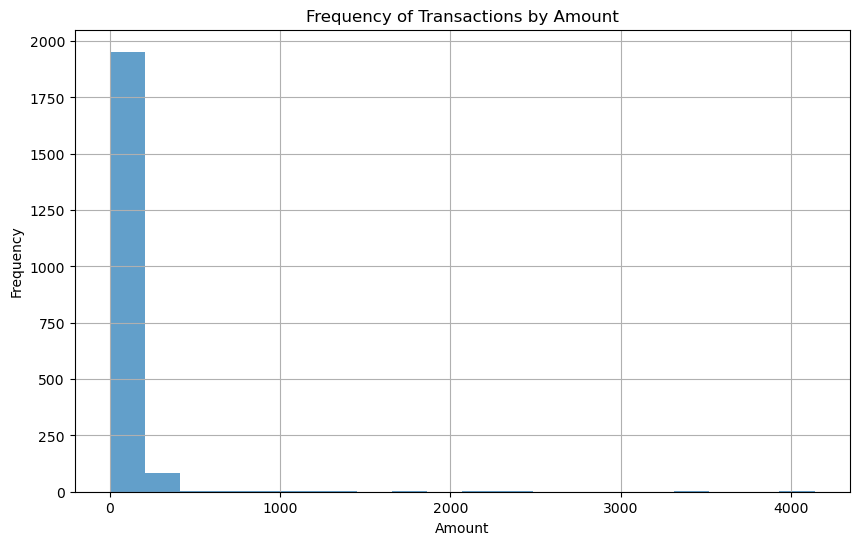

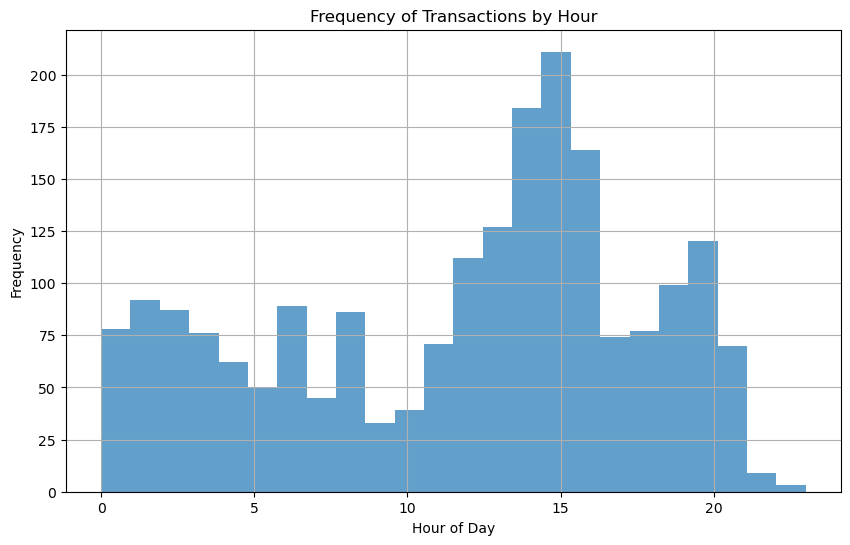

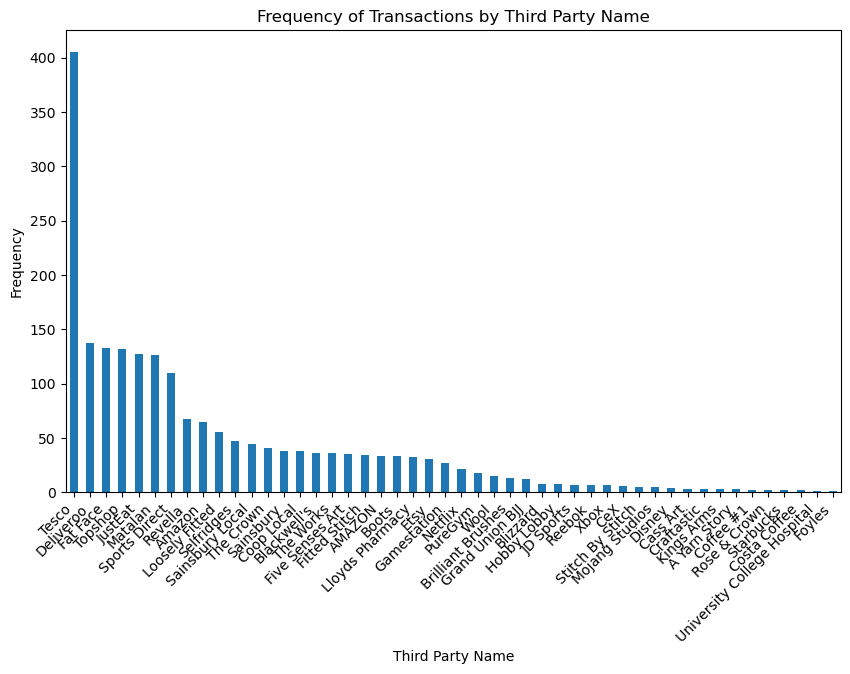

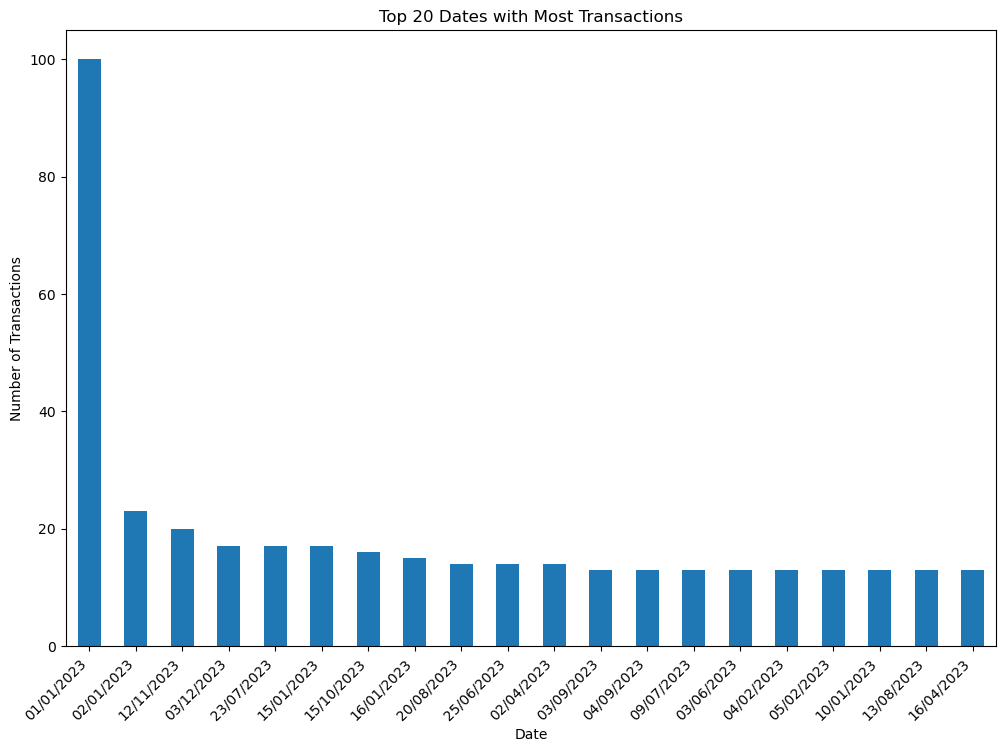

In [39]:
# Amount Frequencies
plt.figure(figsize=(10, 6))
anomalies_df['Amount'].plot(kind='hist', bins=20, alpha=0.7)
plt.title('Frequency of Transactions by Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Frequency of Transactions by Hour
plt.figure(figsize=(10, 6))
anomalies_df['Hour'].plot(kind='hist', bins=24, alpha=0.7, range=(0, 23))
plt.title('Frequency of Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Frequency of Transactions by Third Party Name
plt.figure(figsize=(10, 6))
anomalies_df['Third Party Name'].value_counts().plot(kind='bar')
plt.title('Frequency of Transactions by Third Party Name')
plt.xlabel('Third Party Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.show()

top_20_dates = anomalies_df['Date'].value_counts().nlargest(20)

plt.figure(figsize=(12, 8))
top_20_dates.plot(kind='bar')
plt.title('Top 20 Dates with Most Transactions')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha="right")
plt.show()

### Payments Df

In [41]:
training_payments_df

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime
198746,01/11/2023,00:00:00,408057540.0,5381.727073,2841.66,NaN,Green Park Academy,2023-11-01 00:00:00
38569,28/02/2023,00:00:00,491392945.0,3166.941900,3087.75,NaN,CPA,2023-02-28 00:00:00
134142,01/08/2023,00:00:00,550644516.0,1430.229200,1620.10,NaN,Costa Coffee,2023-08-01 00:00:00
153936,31/08/2023,00:00:00,769311479.0,8076.394632,2783.00,NaN,Collector Cave,2023-08-31 00:00:00
199002,31/10/2023,23:59:00,548907062.0,158.583489,690.00,865748375.0,NaN,2023-10-31 23:59:00
...,...,...,...,...,...,...,...,...
112103,29/06/2023,23:59:00,496865819.0,672.111568,650.00,466649401.0,NaN,2023-06-29 23:59:00
174948,30/09/2023,00:00:00,473820682.0,13117.794693,3126.00,NaN,University College Hospital,2023-09-30 00:00:00
113460,01/07/2023,00:00:00,227104649.0,2733.642784,1675.00,NaN,A Yarn Story,2023-07-01 00:00:00
133975,01/08/2023,00:00:00,610645022.0,1548.003437,1644.00,NaN,North Face,2023-08-01 00:00:00


In [44]:
training_payments_df['Hour'] = training_payments_df['Datetime'].dt.hour

# Group by 'Account No' and 'Hour', then count the frequency of each 'Hour' for an account
hourly_interactions_payment = training_payments_df.groupby(['Account No', 'Hour']).size().reset_index(name='Frequency')

# Find the hours with the least frequency for each account
least_frequent_hours_payment = hourly_interactions_payment.sort_values(['Account No', 'Frequency', 'Hour']).drop_duplicates('Account No', keep='first')

def find_hours_in_lowest_quintile(group):
    # Determine the 10th percentile (lowest quintile) of frequency for the group
    threshold = group['Frequency'].quantile(0.1)
    # Return all hours where the frequency is less than or equal to this threshold
    return group[group['Frequency'] <= threshold]['Hour'].tolist()

# Group by 'Account No' to calculate and gather hours in the lowest quintile for each account
accounts_least_frqt_hour = hourly_interactions_payment.groupby('Account No').apply(find_hours_in_lowest_quintile).reset_index(name='Hours in Lowest 20% Quintile')
accounts_least_frqt_hour.set_index('Account No', inplace=True)
accounts_hours_dict = accounts_least_frqt_hour['Hours in Lowest 20% Quintile'].to_dict()

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/1229386972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_payments_df['Hour'] = training_payments_df['Datetime'].dt.hour


In [45]:
testing_payments_df['Hour'] = testing_payments_df['Datetime'].dt.hour

def check_anomaly(row):
    account_no = row['Account No']
    hour = row['Hour']
    least_frqt_hours = accounts_hours_dict.get(account_no, [])
    return hour in least_frqt_hours

# Apply the function to each row in the testing dataframe
testing_payments_df['Anomaly'] = testing_payments_df.apply(check_anomaly, axis=1)

# Filter the testing_expenditures_df to only include rows where 'Anomaly' is True
anomalies_df = testing_payments_df[testing_payments_df['Anomaly'] == True]

anomalies_df

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/3868345476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_payments_df['Hour'] = testing_payments_df['Datetime'].dt.hour
/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/3868345476.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_payments_df['Anomaly'] = testing_payments_df.apply(check_anomaly, axis=1)


,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,Hour,Anomaly
132710,31/07/2023,00:00:00,867987292.0,3672.902680,1584.0,NaN,Happy Days Home,2023-07-31 00:00:00,0,True
113440,01/07/2023,00:00:00,169006407.0,11204.920358,2870.0,NaN,Pets Corner,2023-07-01 00:00:00,0,True
132702,31/07/2023,00:00:00,130154096.0,2806.421548,2708.0,NaN,LBG,2023-07-31 00:00:00,0,True
219580,29/11/2023,23:59:00,570323670.0,4337.961177,1430.0,585133606.0,NaN,2023-11-29 23:59:00,23,True
132839,30/07/2023,23:59:00,845648250.0,764.836050,600.0,994947671.0,NaN,2023-07-30 23:59:00,23,True
...,...,...,...,...,...,...,...,...,...,...
219728,30/11/2023,00:00:00,305778936.0,11584.253231,2918.0,NaN,Remedy plus care,2023-11-30 00:00:00,0,True
94249,01/06/2023,00:00:00,736340277.0,7599.114519,2472.0,NaN,Lavender Primary,2023-06-01 00:00:00,0,True
153839,31/08/2023,00:00:00,352291960.0,2352.307703,1950.0,NaN,Head,2023-08-31 00:00:00,0,True
74238,30/04/2023,00:00:00,366477356.0,3292.956750,3333.0,NaN,Lloyds Pharmacy,2023-04-30 00:00:00,0,True


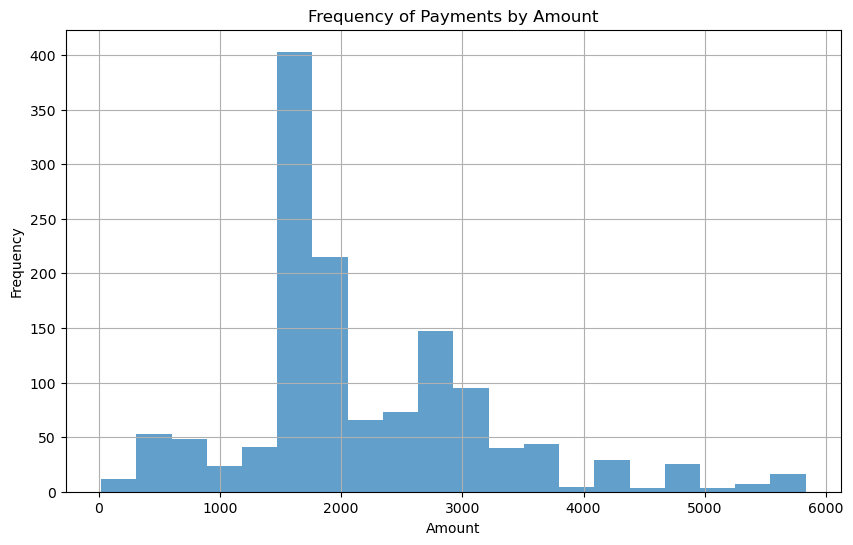

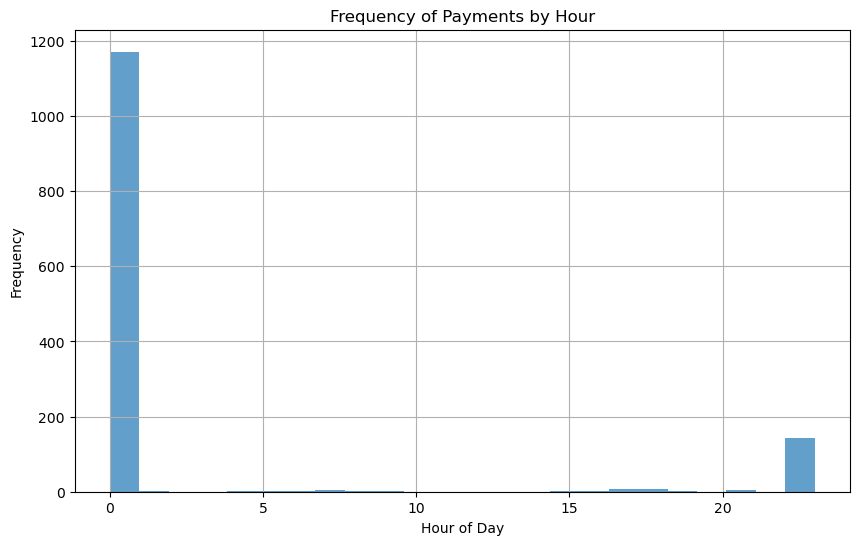

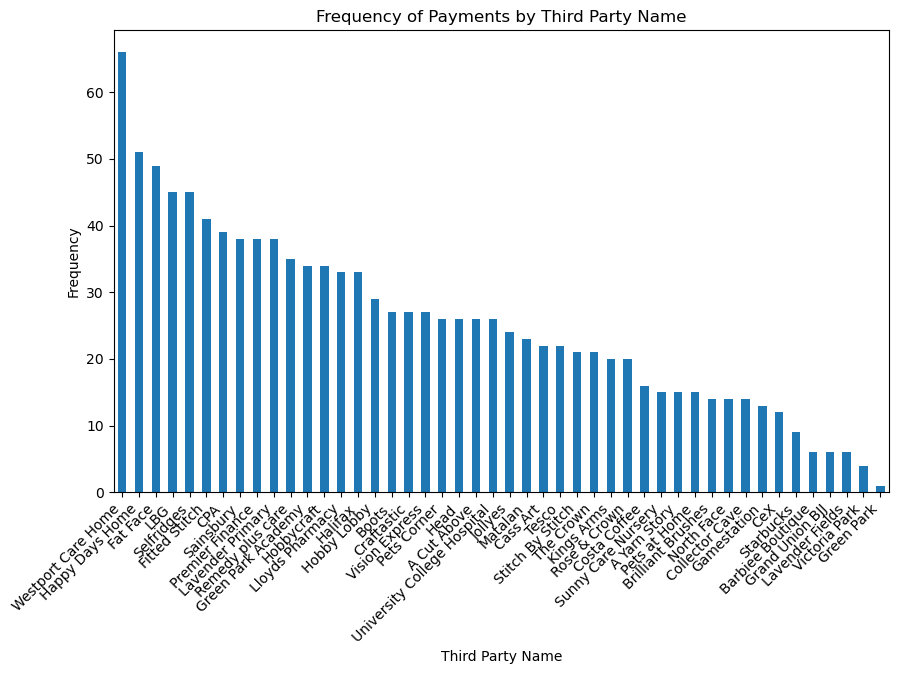

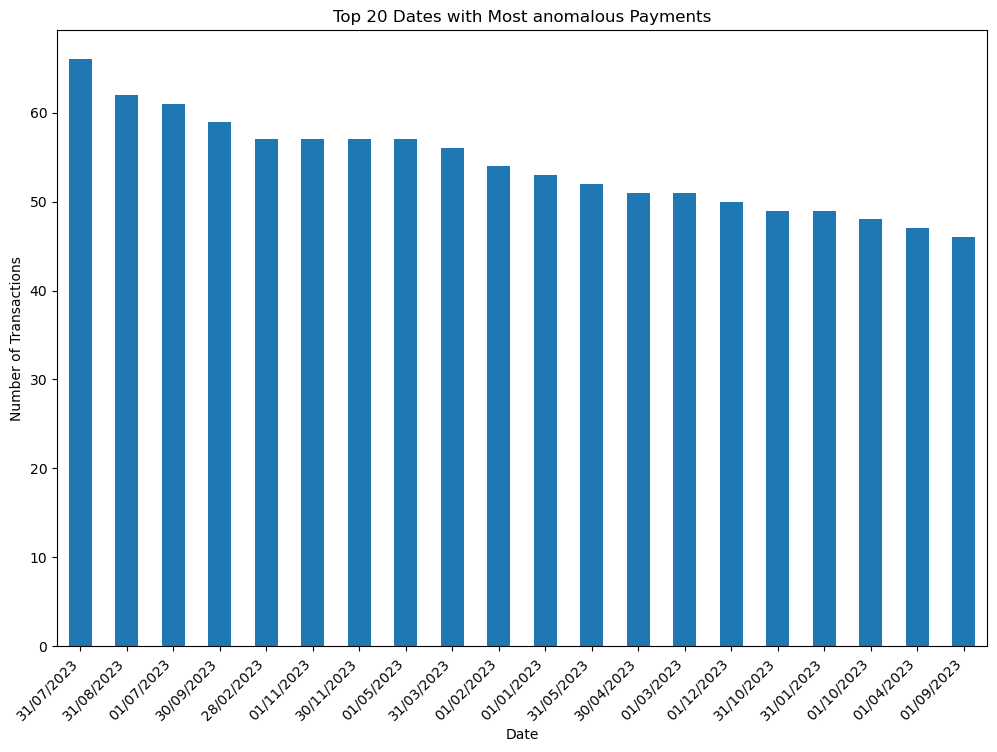

In [46]:
# Amount Frequencies
plt.figure(figsize=(10, 6))
anomalies_df['Amount'].plot(kind='hist', bins=20, alpha=0.7)
plt.title('Frequency of Payments by Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Frequency of Transactions by Hour
plt.figure(figsize=(10, 6))
anomalies_df['Hour'].plot(kind='hist', bins=24, alpha=0.7, range=(0, 23))
plt.title('Frequency of Payments by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Frequency of Transactions by Third Party Name
plt.figure(figsize=(10, 6))
anomalies_df['Third Party Name'].value_counts().plot(kind='bar')
plt.title('Frequency of Payments by Third Party Name')
plt.xlabel('Third Party Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.show()

top_20_dates = anomalies_df['Date'].value_counts().nlargest(20)

plt.figure(figsize=(12, 8))
top_20_dates.plot(kind='bar')
plt.title('Top 20 Dates with Most anomalous Payments')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha="right")
plt.show()

## Isolation Forest Model

In [36]:
training_expenditures_df['DayOfWeek'] = training_expenditures_df['Datetime'].dt.dayofweek
training_expenditures_df['DayOfMonth'] = training_expenditures_df['Datetime'].dt.day
training_expenditures_df['MonthOfYear'] = training_expenditures_df['Datetime'].dt.month


testing_expenditures_df['DayOfWeek'] = testing_expenditures_df['Datetime'].dt.dayofweek
testing_expenditures_df['DayOfMonth'] = testing_expenditures_df['Datetime'].dt.day
testing_expenditures_df['MonthOfYear'] = testing_expenditures_df['Datetime'].dt.month

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/3712909729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_expenditures_df['DayOfWeek'] = training_expenditures_df['Datetime'].dt.dayofweek
/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/3712909729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_expenditures_df['DayOfMonth'] = training_expenditures_df['Datetime'].dt.day
/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/3712909729.py:3:

In [25]:
patterns_train = training_expenditures_df.groupby(['Account No', 'Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Datetime'])['Amount'].sum().reset_index()
patterns_test = testing_expenditures_df.groupby(['Account No', 'Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Datetime'])['Amount'].sum().reset_index()

In [26]:
patterns_train

,Account No,Hour,DayOfWeek,DayOfMonth,MonthOfYear,Datetime,Amount
0,101531259.0,0,0,1,5,2023-05-01 00:00:00,859.00
1,101531259.0,0,1,1,8,2023-08-01 00:00:00,859.00
2,101531259.0,0,2,1,3,2023-03-01 00:00:00,859.00
3,101531259.0,0,2,1,11,2023-11-01 00:00:00,859.00
4,101531259.0,0,3,1,6,2023-06-01 00:00:00,859.00
...,...,...,...,...,...,...,...
149827,999752672.0,23,4,30,6,2023-06-30 23:59:00,15.99
149828,999752672.0,23,4,31,3,2023-03-31 23:59:00,15.99
149829,999752672.0,23,5,29,4,2023-04-29 23:59:00,680.00
149830,999752672.0,23,5,30,9,2023-09-30 23:59:00,15.99


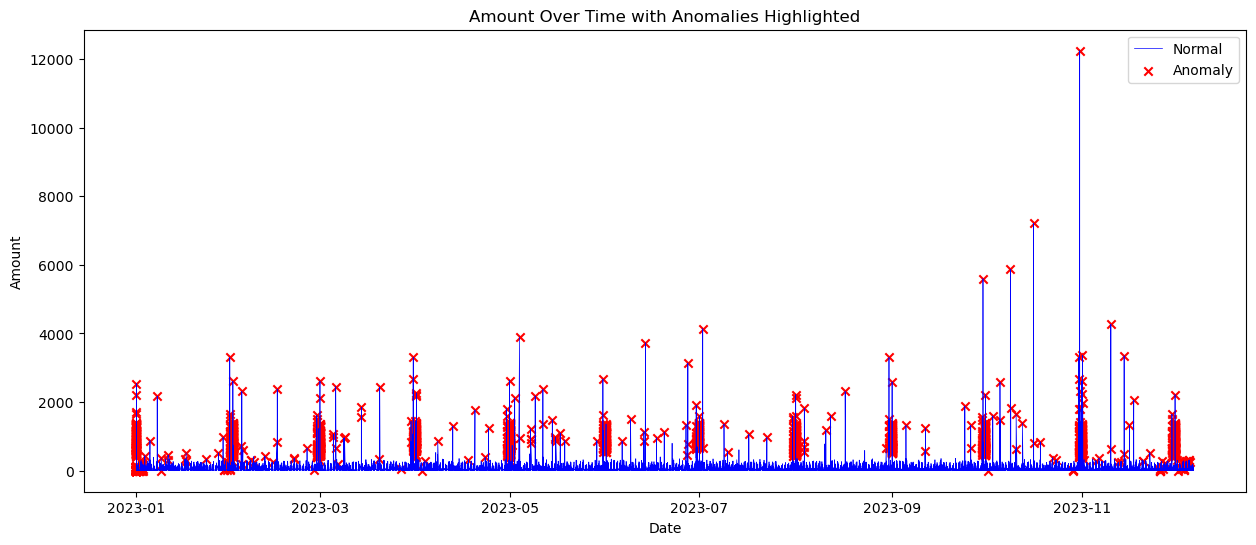

In [27]:
import matplotlib.pyplot as plt

# Assuming patterns_train and patterns_test are your training and test dataframes
# and 'Datetime' column exists in your patterns_test dataframe with actual datetime values.

# Normalize/Standardize features
X_train = patterns_train[['Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Amount']]
X_test = patterns_test[['Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Amount']]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=0.05)
model.fit(X_train_scaled)

# Predict anomalies
test_preds = model.predict(X_test_scaled)
patterns_test['anomaly'] = test_preds

# Merge the predictions with the original test DataFrame
test_data_with_preds = patterns_test.copy()
test_data_with_preds['Date'] = pd.to_datetime(test_data_with_preds['Datetime'])

# Sort by date for plotting
test_data_with_preds.sort_values('Date', inplace=True)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_data_with_preds['Date'], test_data_with_preds['Amount'], label='Normal', color='blue', linestyle='-', linewidth=0.5)
plt.scatter(test_data_with_preds.loc[test_data_with_preds['anomaly'] == -1, 'Date'],
            test_data_with_preds.loc[test_data_with_preds['anomaly'] == -1, 'Amount'],
            color='red', label='Anomaly', marker='x')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Amount Over Time with Anomalies Highlighted')
plt.legend()
plt.show()


## Some EDA for frequency of transactions

In [28]:
df_copy.set_index('Datetime', inplace=True)
payments_df = df_copy[df_copy['Amount'] > 0]
expenditures_df = df_copy[df_copy['Amount'] < 0]
expenditures_df["Amount"] = expenditures_df["Amount"].abs()

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/2036389683.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenditures_df["Amount"] = expenditures_df["Amount"].abs()


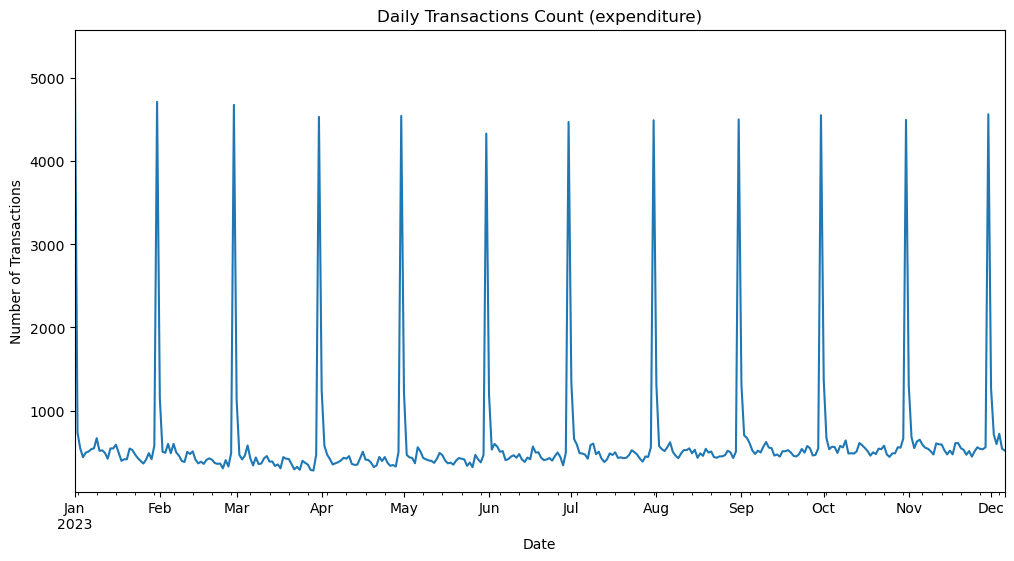

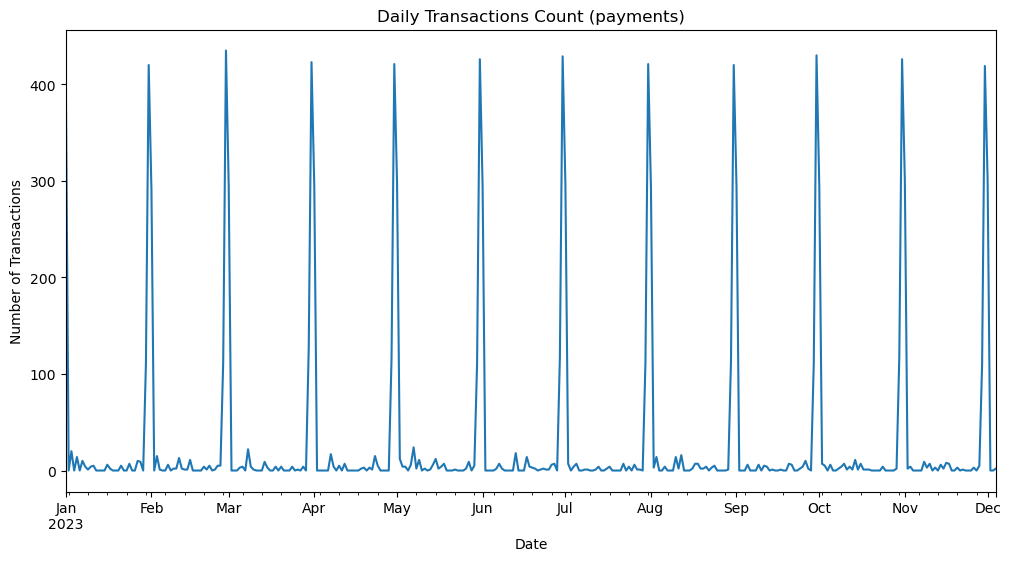

In [29]:
# Sum of all daily transactions
daily_transactions = expenditures_df.resample('D').size()

# Plot
plt.figure(figsize=(12, 6))
daily_transactions.plot(title='Daily Transactions Count (expenditure)')
plt.ylabel('Number of Transactions')
plt.xlabel('Date')
plt.show()

# Sum of all daily transactions
daily_transactions = payments_df.resample('D').size()

# Plot
plt.figure(figsize=(12, 6))
daily_transactions.plot(title='Daily Transactions Count (payments)')
plt.ylabel('Number of Transactions')
plt.xlabel('Date')
plt.show()

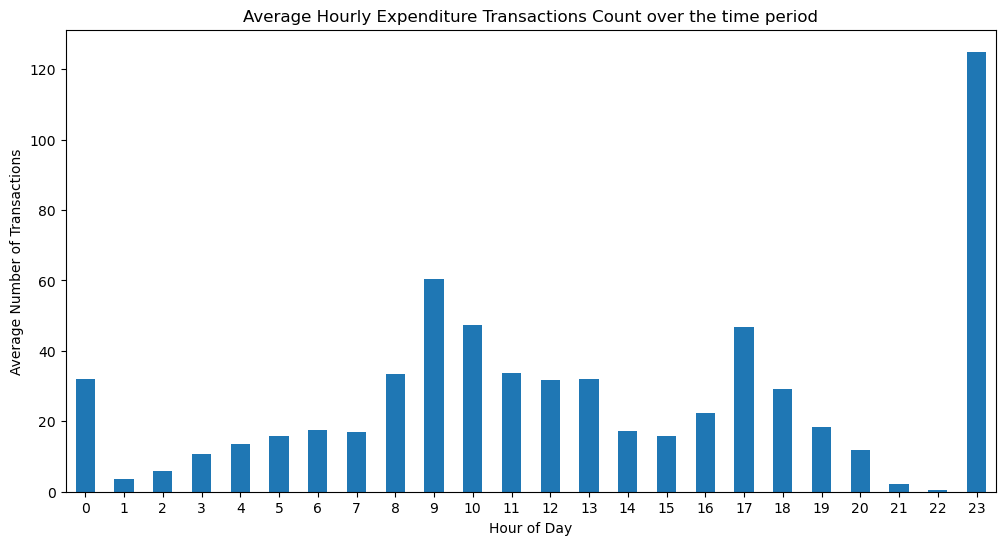

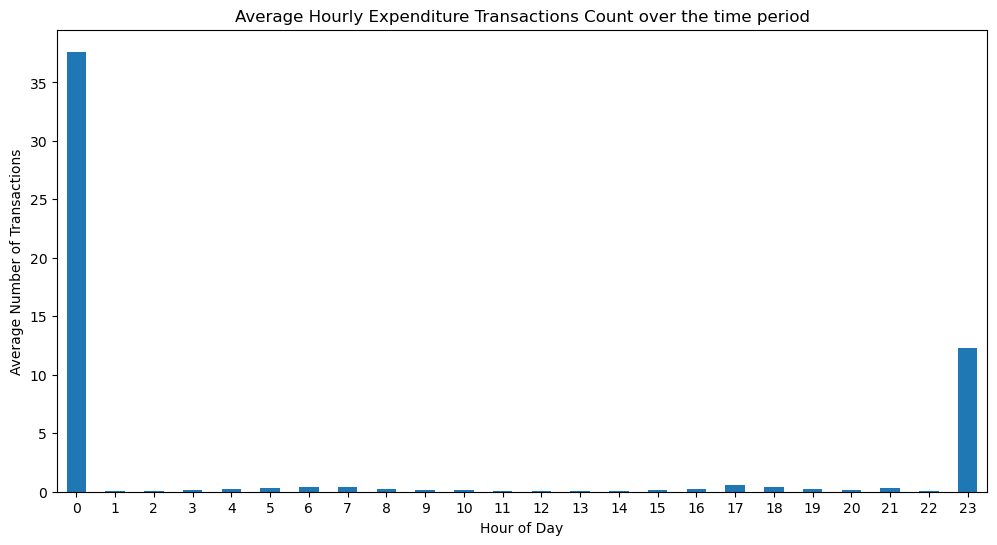

In [30]:
# Calculate the number of unique dates (days) in the DataFrame
unique_days = pd.Series(expenditures_df.index.date).nunique()

# Group by hour and count transactions, then divide by the number of unique days
hourly_transactions = expenditures_df.groupby(expenditures_df.index.hour).size() / unique_days

# Plot
plt.figure(figsize=(12, 6))
hourly_transactions.plot(kind='bar', title='Average Hourly Expenditure Transactions Count over the time period')
plt.ylabel('Average Number of Transactions')
plt.xlabel('Hour of Day')
plt.xticks(rotation=0)
plt.show()

# Calculate the number of unique dates (days) in the DataFrame
unique_days = pd.Series(payments_df.index.date).nunique()

# Group by hour and count transactions, then divide by the number of unique days
hourly_transactions = payments_df.groupby(payments_df.index.hour).size() / unique_days

# Plot
plt.figure(figsize=(12, 6))
hourly_transactions.plot(kind='bar', title='Average Hourly Expenditure Transactions Count over the time period')
plt.ylabel('Average Number of Transactions')
plt.xlabel('Hour of Day')
plt.xticks(rotation=0)
plt.show()



/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/2188435756.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_amount_spent = expenditures_df.resample('W').sum()['Amount']


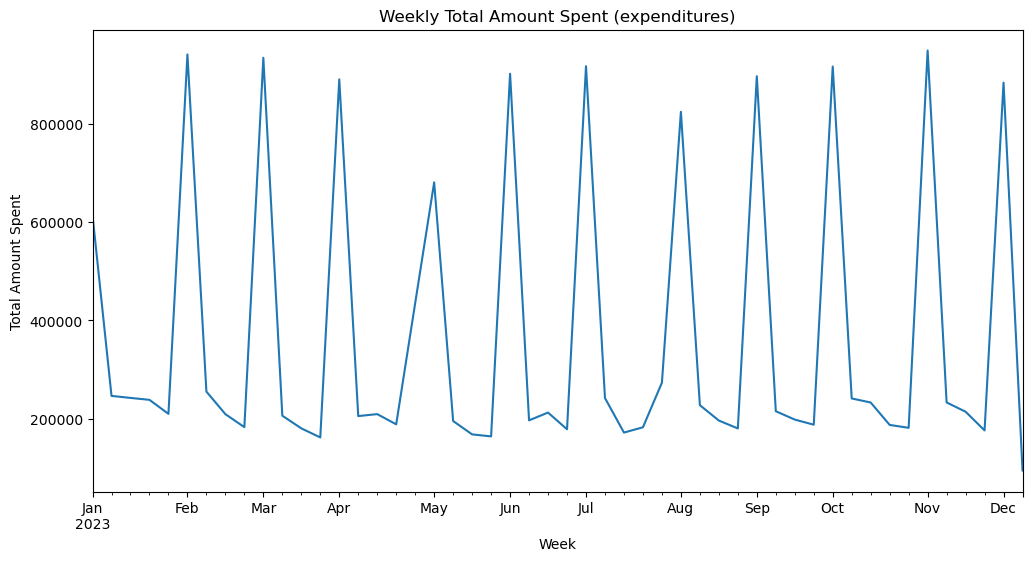

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_50653/2188435756.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_amount_spent = payments_df.resample('W').sum()['Amount']


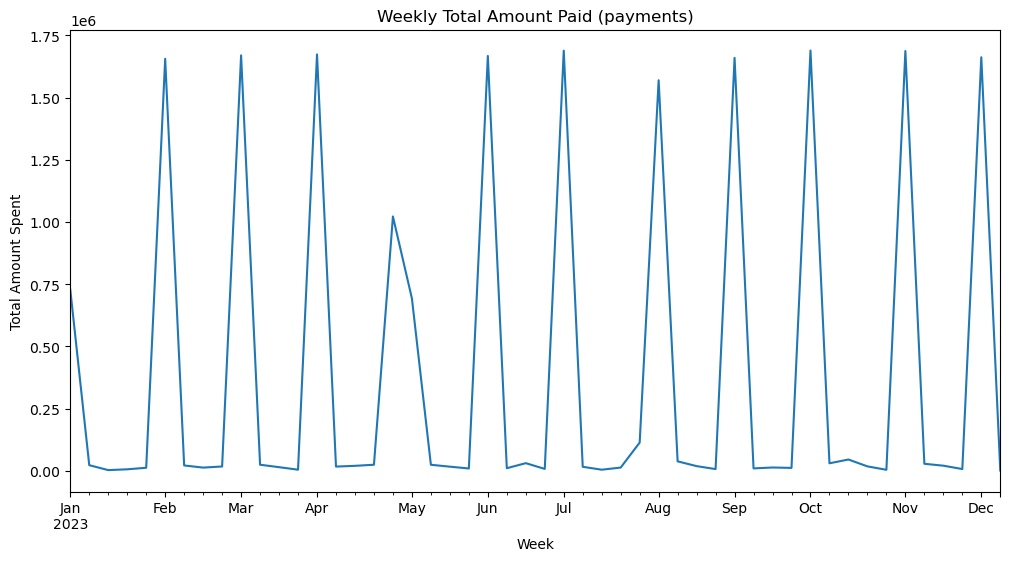

In [31]:
# Sum of amount spent each week
weekly_amount_spent = expenditures_df.resample('W').sum()['Amount']

# Plot
plt.figure(figsize=(12, 6))
weekly_amount_spent.plot(title='Weekly Total Amount Spent (expenditures)')
plt.ylabel('Total Amount Spent')
plt.xlabel('Week')
plt.show()

# Sum of amount spent each week
weekly_amount_spent = payments_df.resample('W').sum()['Amount']

# Plot
plt.figure(figsize=(12, 6))
weekly_amount_spent.plot(title='Weekly Total Amount Paid (payments)')
plt.ylabel('Total Amount Spent')
plt.xlabel('Week')
plt.show()
